### We are calculating the 

In [2]:
#pip install climate_indices

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.metrics import mean_squared_error
from climate_indices import indices
from climate_indices.compute import scale_values, Periodicity

In [4]:
#Importanat Definations

In [5]:
# resuable code

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def daily_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"daily": variable,
	"models": ["era5_seamless"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_sum = daily.Variables(0).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
	)}
	daily_data["open_meteo"] = daily_sum

	daily_dataframe = pd.DataFrame(data = daily_data)
	if daily_dataframe.empty:
		return print("The daily limit reached")
	return daily_dataframe

def calculate_accuracy(original_data, predicted_data):
	mbe = np.mean(predicted_data - original_data)
	rmse = np.sqrt(mean_squared_error(original_data, predicted_data))
	correlation = np.corrcoef(original_data, predicted_data)[0, 1]

	# Print results
	print(f"Mean Bias Error (MBE): {mbe}")
	print(f"Root Mean Square Error (RMSE): {rmse}")
	print(f"Correlation: {correlation}")
	

# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def Hourly_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"hourly": variable,
	"models": ["era5_seamless"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_snow_depth = hourly.Variables(0).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	hourly_data["open_meteo"] = hourly_snow_depth

	hourly_dataframe = pd.DataFrame(data = hourly_data)

	if hourly_dataframe.empty:
		return print("The daily limit reached")
	return hourly_dataframe

# font size
f_title = 14
f_other = 12

#CODE NOT IN USE FOR THIS JBOOK
# # plots
# def plot_my_bargraph(length:int,breath:int,xaxis,yaxis,title:str,xlabel:str,ylabel:str, widthv=0.5, colorv='blue',xtick = False):
#     plt.figure(figsize=(length, breath))
#     plt.bar(xaxis, yaxis, width = widthv , color=colorv)
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.grid(axis='y')
#     if xtick == True:
#         plt.xticks(xaxis,rotation=45,fontsize=10)
#     plt.tight_layout()
#     plt.show()



# def plot_my_bargraph_withnumbers(length:int,breath:int,xaxis,yaxis,title:str,xlabel:str,ylabel:str, widthv=0.5, colorv='blue'):
#     plt.figure(figsize=(length, breath))
#     plt.bar(xaxis, yaxis, width = widthv , color=colorv)
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.grid(axis='y')
#     for i, value in enumerate(yaxis):
#         plt.text(xaxis[i], value + 1, str(value), ha='center', fontsize=9)
#     plt.tight_layout()
#     plt.xticks(xaxis,rotation=45,fontsize=10)
#     plt.show()

def Convert_the_data_into_10_year_avergae(Dataframe):
    bins = range(1950, 2030, 10)  # Decade bins
    Dataframe.index = Dataframe.index.astype(int) 

    # Sum the total cold days for each decade and divide by 10
    averrage_days_by_decade = (Dataframe.groupby(pd.cut(Dataframe.index, bins)).sum() / 10) #Change the method for the Decade calculation.
    averrage_days_by_decade.index = averrage_days_by_decade.index.astype(str)
    return averrage_days_by_decade

## calcluating SEPI index

#### Vicente-Serrano, S. M., Beguería, S., & López-Moreno, J. I. (2010). "A Multiscalar Drought Index Sensitive to Global Warming: The Standardized Precipitation Evapotranspiration Index." Journal of Climate, 23(7), 1696–1718. https://doi.org/10.1175/2009JCLI2909.1

#### Projecting Hydroclimatic Extremes: Climate Change Impacts on Drought in a German Low Mountain Range Catchment



## Steps 
#### 1. Get the data from the API.
#### 2. Convert it to monthly (Monthly Mean)
#### 3. Calcluate D (D = p - et0)
#### 4. Normalize it using Climate Indicies library python.
#### plot the result. 


In [6]:
#open_meto_1950_2023_precipitation = daily_open_meteo_data("1950-01-01", "2023-12-31",[51.8], [10.62],"precipitation_sum")

In [7]:
#open_meto_1950_2023_et0 = daily_open_meteo_data("1950-01-01", "2023-12-31",[51.8], [10.62],"et0_fao_evapotranspiration")

### we are using the "Avereage_data_for_Harz.ipynb" to calculate the average.
### from Et0_average.xlsx and precipitation_average

In [8]:
open_meto_1950_2023_et0 = pd.read_excel(r'Et0_average.xlsx')
open_meto_1950_2023_precipitation = pd.read_excel(r'precipitation_avergae.xlsx')

In [9]:
#open_meto_1950_2023_et0.drop(['Unnamed: 0'],inplace=True)
open_meto_1950_2023_et0 

,date,average_et0
0,1949-12-31 23:00:00,0.455606
1,1950-01-01 23:00:00,0.794405
2,1950-01-02 23:00:00,0.205808
3,1950-01-03 23:00:00,0.245390
4,1950-01-04 23:00:00,0.170557
...,...,...
27023,2023-12-26 23:00:00,0.339704
27024,2023-12-27 23:00:00,1.193583
27025,2023-12-28 23:00:00,0.773106
27026,2023-12-29 23:00:00,0.549618


In [10]:
open_meto_1950_2023_precipitation

,date,average_precipitation
0,1949-12-31 23:00:00,0.000000
1,1950-01-01 23:00:00,10.900001
2,1950-01-02 23:00:00,2.240000
3,1950-01-03 23:00:00,1.680000
4,1950-01-04 23:00:00,5.220000
...,...,...
27023,2023-12-26 23:00:00,0.300000
27024,2023-12-27 23:00:00,0.040000
27025,2023-12-28 23:00:00,6.660000
27026,2023-12-29 23:00:00,2.320000


### Converting it into monthly data

In [11]:
# Precipitation data
open_meto_1950_2023_precipitation.set_index('date',inplace = True)
open_meto_1950_2023_precipitation.fillna(0,inplace=True) # to be sure it do not contain NAN values
open_meto_1950_2023_precipitation_monthly = open_meto_1950_2023_precipitation.resample("M").mean()
open_meto_1950_2023_precipitation_monthly.rename(columns={'average_precipitation': 'precipitation'}, inplace=True)

In [12]:
open_meto_1950_2023_precipitation_monthly.head()

,precipitation
date,
1949-12-31,0.000000
1950-01-31,1.674839
1950-02-28,3.137857
1950-03-31,0.954839
1950-04-30,2.612000


In [13]:
# Eto data
open_meto_1950_2023_et0.set_index('date',inplace = True)
open_meto_1950_2023_et0.fillna(0,inplace=True) # to be sure it do not contain NAN values
open_meto_1950_2023_eto_monthly = open_meto_1950_2023_et0.resample("M").mean()
open_meto_1950_2023_eto_monthly.rename(columns={'average_et0': 'ET0'}, inplace=True)

In [14]:
open_meto_1950_2023_eto_monthly.head()

,ET0
date,
1949-12-31,0.455606
1950-01-31,0.451574
1950-02-28,0.715936
1950-03-31,1.245547
1950-04-30,1.801720


### Calculating water balance (WB)

In [15]:
WB_1950_2023_SPEI_monthly = open_meto_1950_2023_eto_monthly

In [16]:
WB_1950_2023_SPEI_monthly['Deficit'] = open_meto_1950_2023_precipitation_monthly['precipitation'] - open_meto_1950_2023_eto_monthly['ET0']

### Using the climate-indices library to calcluate the SPEI.
### Climate-indices: https://pypi.org/project/climate_indices/




# Citation
author = "James Adams",
title  = "climate_indices, an open source Python library providing reference implementations of commonly used climate indices",
url    = "https://github.com/monocongo/climate_indices",
month  = "may",
year   = "2017--"

In [17]:
## defination for Calculating the SPEI
def compute_SPEI(distribution,scale,pet,precips):
    spei_values = indices.spei(
    pet_mm= pet.values,
    precips_mm= precips.values,
    scale=scale,
    distribution=distribution,
    data_start_year=1950,
    calibration_year_initial=1950,
    calibration_year_final=2023,
    periodicity= Periodicity.monthly,
)
    return spei_values


#data[name_field] = spei_values

In [18]:
 # Use Gamma distribution, and 3 month scale
distribution = indices.Distribution.gamma 

WB_1950_2023_SPEI_monthly['SPEI2'] = compute_SPEI(distribution,2,open_meto_1950_2023_eto_monthly['ET0'],open_meto_1950_2023_precipitation_monthly['precipitation'])
WB_1950_2023_SPEI_monthly['SPEI3'] = compute_SPEI(distribution,3,open_meto_1950_2023_eto_monthly['ET0'],open_meto_1950_2023_precipitation_monthly['precipitation'])
WB_1950_2023_SPEI_monthly['SPEI6'] = compute_SPEI(distribution,6,open_meto_1950_2023_eto_monthly['ET0'],open_meto_1950_2023_precipitation_monthly['precipitation'])
WB_1950_2023_SPEI_monthly['SPEI12'] = compute_SPEI(distribution,12,open_meto_1950_2023_eto_monthly['ET0'],open_meto_1950_2023_precipitation_monthly['precipitation'])

In [19]:
WB_1950_2023_SPEI_monthly

,ET0,Deficit,SPEI2,SPEI3,SPEI6,SPEI12
date,,,,,,
1949-12-31,0.455606,-0.455606,NaN,NaN,NaN,NaN
1950-01-31,0.451574,1.223265,-2.029300,NaN,NaN,NaN
1950-02-28,0.715936,2.421921,0.915711,-0.879037,NaN,NaN
1950-03-31,1.245547,-0.290708,0.287169,0.055158,NaN,NaN
1950-04-30,1.801720,0.810280,0.085899,0.781096,NaN,NaN
...,...,...,...,...,...,...
2023-08-31,2.937446,0.179973,0.069178,-0.537040,-0.490230,-0.302145
2023-09-30,2.715662,-1.391662,-0.396478,-0.532123,-1.302011,-0.920391
2023-10-31,1.231677,2.176710,0.066877,0.446366,-0.835522,-0.459062


In [20]:
SPEI__monthly = WB_1950_2023_SPEI_monthly.copy()
SPEI__monthly.drop(['ET0', 'Deficit'],axis=1,inplace=True)
SPEI__monthly

,SPEI2,SPEI3,SPEI6,SPEI12
date,,,,
1949-12-31,NaN,NaN,NaN,NaN
1950-01-31,-2.029300,NaN,NaN,NaN
1950-02-28,0.915711,-0.879037,NaN,NaN
1950-03-31,0.287169,0.055158,NaN,NaN
1950-04-30,0.085899,0.781096,NaN,NaN
...,...,...,...,...
2023-08-31,0.069178,-0.537040,-0.490230,-0.302145
2023-09-30,-0.396478,-0.532123,-1.302011,-0.920391
2023-10-31,0.066877,0.446366,-0.835522,-0.459062


In [21]:
SPEI__monthly.fillna(0, inplace=True)

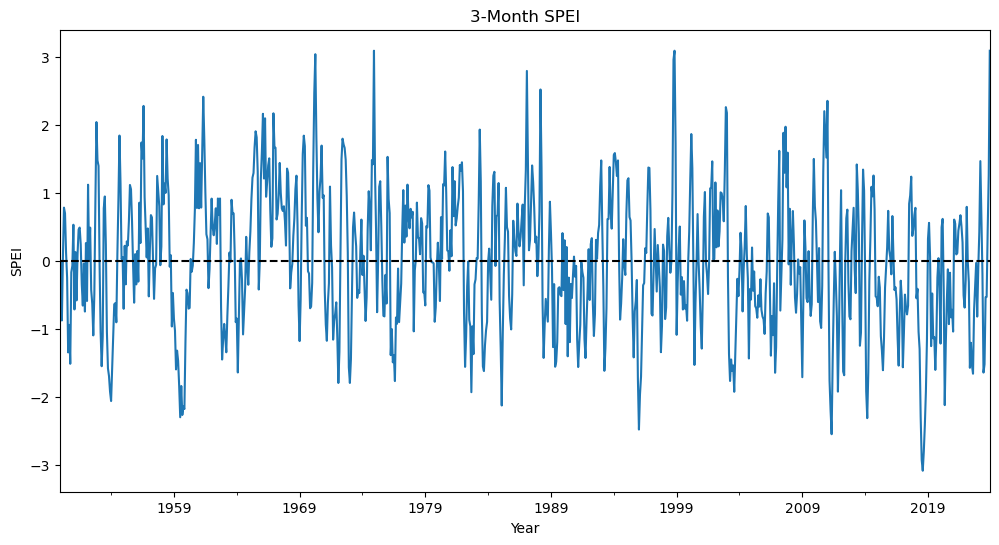

In [22]:
SPEI__monthly['SPEI3'].plot(figsize=(12, 6), title="3-Month SPEI")
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Year') 
plt.ylabel('SPEI')
plt.show()

## Now definig the seasons for better understanding.

In [18]:
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
SPEIs = ['SPEI2', 'SPEI3', 'SPEI6', 'SPEI12']
def seasons_create(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [9, 10, 11]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Winter'
    


In [24]:
SPEI_all_monthly = WB_1950_2023_SPEI_monthly.copy()

In [25]:
SPEI_all_monthly.drop(['ET0', 'Deficit'],axis=1,inplace=True)

In [26]:
#pei_data = SPEI_monthly.copy() 
SPEI_all_monthly['Season'] = SPEI_all_monthly.index.map(seasons_create)

### dividing the time period in 3 part.

In [27]:
SPEI_all_monthly['Year'] = SPEI_all_monthly.index.year
# separate the different year
time_periods = {
    '1950-1980': (1950, 1980),
    '1981-2010': (1981, 2010),
    '2011-2023': (2011, 2023)
}

In [28]:
severe_drought_days = []

In [29]:
severe_drought_days = []

# Loop for time period
for period, (start_year, end_year) in time_periods.items():
    
    period_data = SPEI_all_monthly[(SPEI_all_monthly['Year'] >= start_year) & (SPEI_all_monthly['Year'] <= end_year)]
    
    # Loop for each season
    for season in seasons:
        
        d_season = period_data[period_data['Season'] == season]
        
        # Loop through each SPEI scale
        for spei_scale in SPEIs:
            
            drought_day_count = (d_season[spei_scale] < -1.5).sum()
            
            
            severe_drought_days.append({
                'Period': period,
                'Season': season,
                'SPEI_Scale': spei_scale,
                'Severe_Droughts_days': drought_day_count
            })

In [30]:
pd_severe_drought_days = pd.DataFrame(severe_drought_days)
print(pd_severe_drought_days)

       Period  Season SPEI_Scale  Severe_Droughts_days
0   1950-1980  Spring      SPEI2                     2
1   1950-1980  Spring      SPEI3                     2
2   1950-1980  Spring      SPEI6                     7
3   1950-1980  Spring     SPEI12                     3
4   1950-1980  Summer      SPEI2                     3
5   1950-1980  Summer      SPEI3                     4
6   1950-1980  Summer      SPEI6                     5
7   1950-1980  Summer     SPEI12                     6
8   1950-1980  Autumn      SPEI2                     5
9   1950-1980  Autumn      SPEI3                     6
10  1950-1980  Autumn      SPEI6                     3
11  1950-1980  Autumn     SPEI12                     3
12  1950-1980  Winter      SPEI2                     8
13  1950-1980  Winter      SPEI3                     7
14  1950-1980  Winter      SPEI6                     8
15  1950-1980  Winter     SPEI12                     5
16  1981-2010  Spring      SPEI2                     5
17  1981-2

### Preparing the data to plot

### Seperate the data by season for clear understanding.

In [31]:
time_periods = ['1950-1980', '1981-2010', '2011-2023']


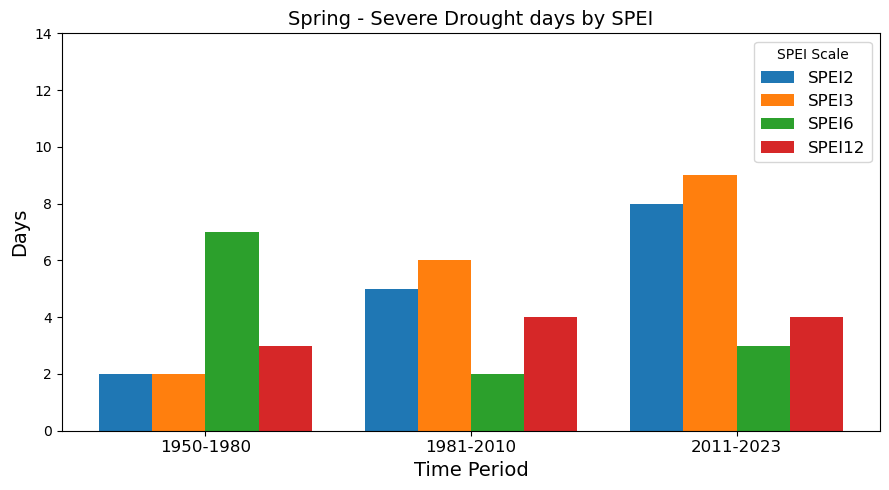

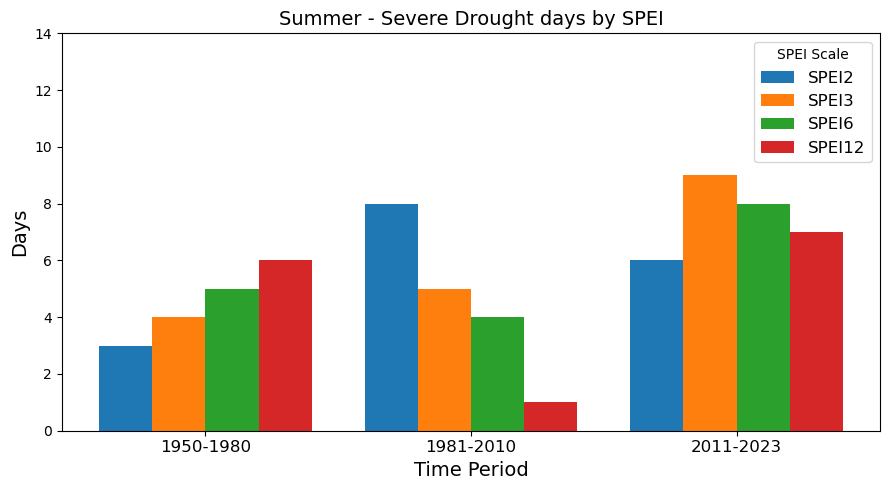

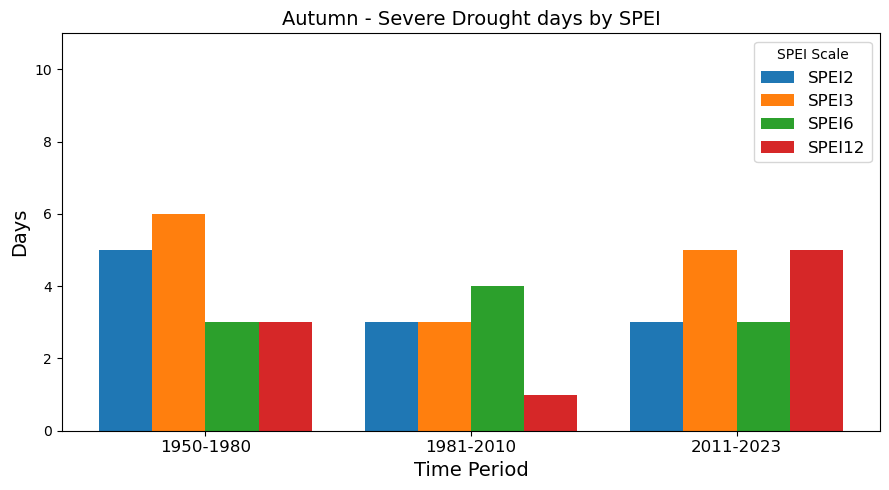

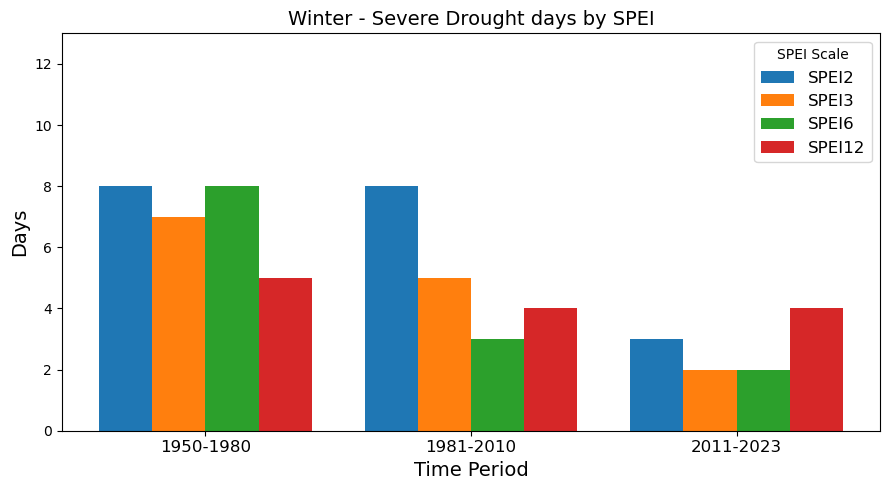

In [33]:
for Season in seasons:
    plt.figure(figsize=(9, 5))
    filtered_data = pd_severe_drought_days[pd_severe_drought_days['Season'] == Season]
    
    bar_width = 0.2 
    x_ticks = np.arange(3) #length of time period.
    
    for i, scale in enumerate(SPEIs):
        D_days_count = []
        
        for period in time_periods:
            period_data = filtered_data[(filtered_data['Period'] == period) & (filtered_data['SPEI_Scale'] == scale)]

            total_days = period_data['Severe_Droughts_days'].sum()
            D_days_count.append(0 if np.isnan(total_days) else total_days) # because all have Null value 
    
        plt.bar(x_ticks + (bar_width * i),  D_days_count, bar_width, label=scale)
    
    
    plt.title(f'{Season} - Severe Drought days by SPEI', fontsize=f_title)
    plt.xlabel('Time Period', fontsize=f_title)
    plt.ylabel('Days', fontsize=f_title)
    #plt.xticks(time_periods)


    plt.xticks(x_ticks + bar_width * (4 - 1) / 2, time_periods, fontsize=f_other) # 4 for different SPEI scale
    plt.ylim(0, max(filtered_data['Severe_Droughts_days'].fillna(0)) + 5)  # to properly fit the values
    plt.legend(title='SPEI Scale', fontsize=f_other)
    
    plt.tight_layout()
    plt.show()

## Analysis on precipitation 

### In order to check the anomalies we take year 1950-1980 as refrence.
### Firstly calclulating the refrence year data and then comparing it with other data.


### Diving the data into seasons 

In [19]:
#open_meto_1950_2023_precipitation
precipitation_all = open_meto_1950_2023_precipitation_monthly.copy()
#Reference_period = open_meto_1950_2023_precipitation.loc["1950-01-01":"1980-12-31"]
precipitation_all['Season'] = precipitation_all.index.map(seasons_create)

In [20]:
#reference Year
precipitation_all['Year'] = precipitation_all.index.year
precipitation_refrence = precipitation_all.loc["1950":"1980"]
precipitation_refrence

,precipitation,Season,Year
date,,,
1950-01-31,1.674839,Winter,1950
1950-02-28,3.137857,Winter,1950
1950-03-31,0.954839,Spring,1950
1950-04-30,2.612000,Spring,1950
1950-05-31,3.352258,Spring,1950
...,...,...,...
1980-08-31,2.256774,Summer,1980
1980-09-30,2.214667,Autumn,1980
1980-10-31,1.336129,Autumn,1980


In [21]:
# Mean for refrence year
precipitation_refrence_mean = precipitation_refrence.groupby('Season')["precipitation"].mean()
precipitation_refrence_mean

Season
Autumn    1.817806
Spring    2.145733
Summer    2.639040
Winter    1.877424
Name: precipitation, dtype: float64

In [22]:
#Anomolies
# anomaly = ((x - y) / y) * 100, 
# where x is the observed precipitation.
# y is the reference mean precipitation.

def get_anomolies_percentatge(data):
    season = data["Season"].iloc[0]
    avg_precipitation = precipitation_refrence_mean[season]
    data["anomaly"] = ((data["precipitation"] - avg_precipitation) /avg_precipitation) * 100
    return data


In [23]:
#test data
precipitation_1981_2023 = precipitation_all.loc["1981":"2023"]

In [58]:
anomalies = precipitation_1981_2023.groupby(["Year", "Season"]).apply(get_anomolies_percentatge)

# keeping usefull column
anomalies = anomalies[["Year", "Season", "precipitation", "anomaly"]]

In [59]:
anomalies

Year  Season  precipitation     anomaly
Year Season date                                               
1981 Autumn 1981-09-30  1981  Autumn       2.720667   49.667606
            1981-10-31  1981  Autumn       2.412903   32.737117
            1981-11-30  1981  Autumn       2.816000   54.912022
     Spring 1981-03-31  1981  Spring       3.694193   72.164665
            1981-04-30  1981  Spring       1.562000  -27.204351
...                      ...     ...            ...         ...
2023 Summer 2023-07-31  2023  Summer       2.429032   -7.957735
            2023-08-31  2023  Summer       3.117419   18.127018
     Winter 2023-01-31  2023  Winter       2.643226   40.790029
            2023-02-28  2023  Winter       1.564286  -16.679143
            2023-12-31  2023  Winter       4.868667  159.326969

[516 rows x 4 columns]

### As the result is not visualy understanable we use 10 year average.
### and add a feature to annonte extreme event.

In [60]:
anomalies_decade = anomalies.copy()
# Reset the index -- Due to error 'Season' is both an index level and a column label, which is ambiguous.
if "Season" in anomalies_decade.columns and "Season" in anomalies_decade.index.names:
    anomalies_decade = anomalies_decade.drop(columns=["Season"])
# creating a new column with decade data to present
anomalies_decade["decade"] = (anomalies_decade["Year"] // 6) * 10   #refrence Year
# mean of 10 years
average_anomalies_by_decade = anomalies_decade.groupby(["decade","Season"]).mean().reset_index()



In [61]:
average_anomalies_by_decade= average_anomalies_by_decade.groupby(["Year", "Season"], as_index=False).mean()
average_anomalies_by_decade

,Year,Season,decade,precipitation,anomaly
0,1985.0,Autumn,1980.0,1.759586,-3.202771
1,1985.0,Spring,1980.0,2.174660,1.348146
2,1985.0,Summer,1980.0,2.220864,-15.845759
3,1985.0,Winter,1980.0,1.963116,4.564344
4,1994.5,Autumn,1990.0,1.968949,8.314590
5,1994.5,Spring,1990.0,1.906858,-11.132543
6,1994.5,Summer,1990.0,2.329761,-11.719396
7,1994.5,Winter,1990.0,1.856521,-1.113399
8,2004.5,Autumn,2000.0,1.945047,6.999681
9,2004.5,Spring,2000.0,2.000214,-6.781790


In [26]:
color = ["blue",'red','green','orange']

In [44]:
anomalies_till_2000 =  anomalies.loc["1981":"1982"]
#anomalies_till_2000_re = anomalies_till_2000.resample("M").mean()
anomalies_till_2000 

Year  Season  precipitation    anomaly
Year Season date                                              
1981 Autumn 1981-09-30  1981  Autumn       2.720667  49.667606
            1981-10-31  1981  Autumn       2.412903  32.737117
            1981-11-30  1981  Autumn       2.816000  54.912022
     Spring 1981-03-31  1981  Spring       3.694193  72.164665
            1981-04-30  1981  Spring       1.562000 -27.204351
            1981-05-31  1981  Spring       3.192903  48.802473
     Summer 1981-06-30  1981  Summer       2.752000   4.280336
            1981-07-31  1981  Summer       2.061290 -21.892421
            1981-08-31  1981  Summer       2.923226  10.768520
     Winter 1981-01-31  1981  Winter       2.385806  27.078725
            1981-02-28  1981  Winter       1.357143 -27.712500
            1981-12-31  1981  Winter       2.603871  38.693816
1982 Autumn 1982-09-30  1982  Autumn       0.523333 -71.210716
            1982-10-31  1982  Autumn       2.160645  18.860057
            1982-11-30  1982  Autumn       1.014000 -44.218471
     Spring 1982-03-31  1982  Spring       1.354194 -36.888991
            1982-04-30  1982  Spring       1.872667 -12.726004
            1982-05-31  1982  Spring       2.250968   4.904389
     Summer 1982-06-30  1982  Summer       2.666667   1.046841
            1982-07-31  1982  Summer       0.768387 -70.883840
            1982-08-31  1982  Summer       2.045806 -22.479147
     Winter 1982-01-31  1982  Winter       1.713548  -8.728745
            1982-02-28  1982  Winter       0.213571 -88.624231
            1982-12-31  1982  Winter       1.978710   5.394928

C:\Users\rande\AppData\Local\Temp\ipykernel_6444\3971666136.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  each_season_data = anomalies_till_2000[anomalies["Season"] == season]


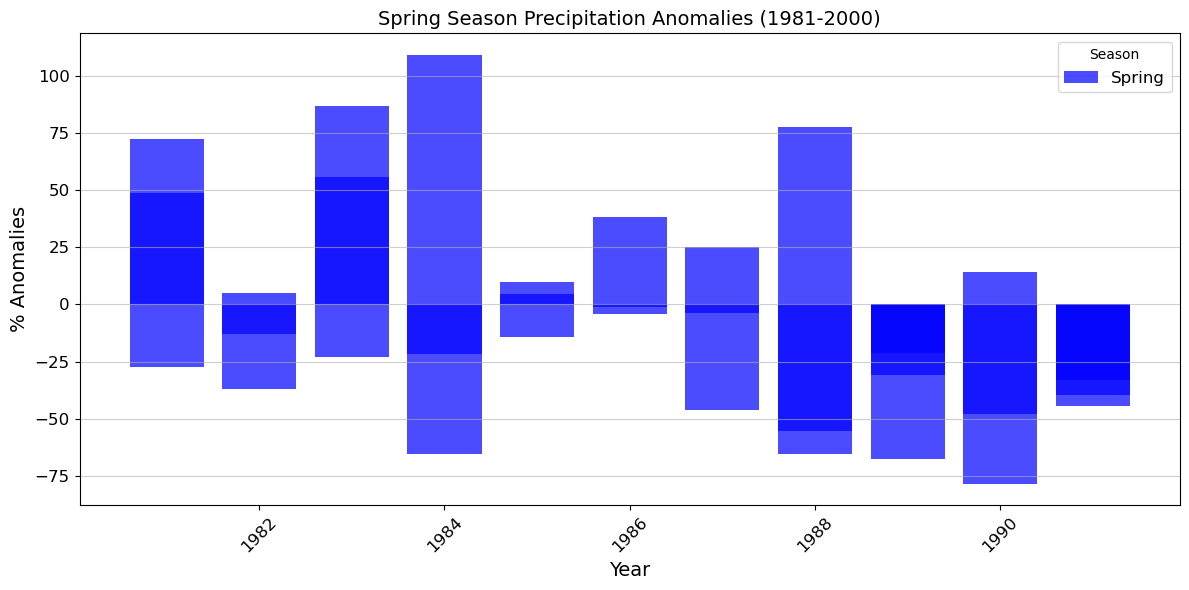

C:\Users\rande\AppData\Local\Temp\ipykernel_6444\3971666136.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  each_season_data = anomalies_till_2000[anomalies["Season"] == season]


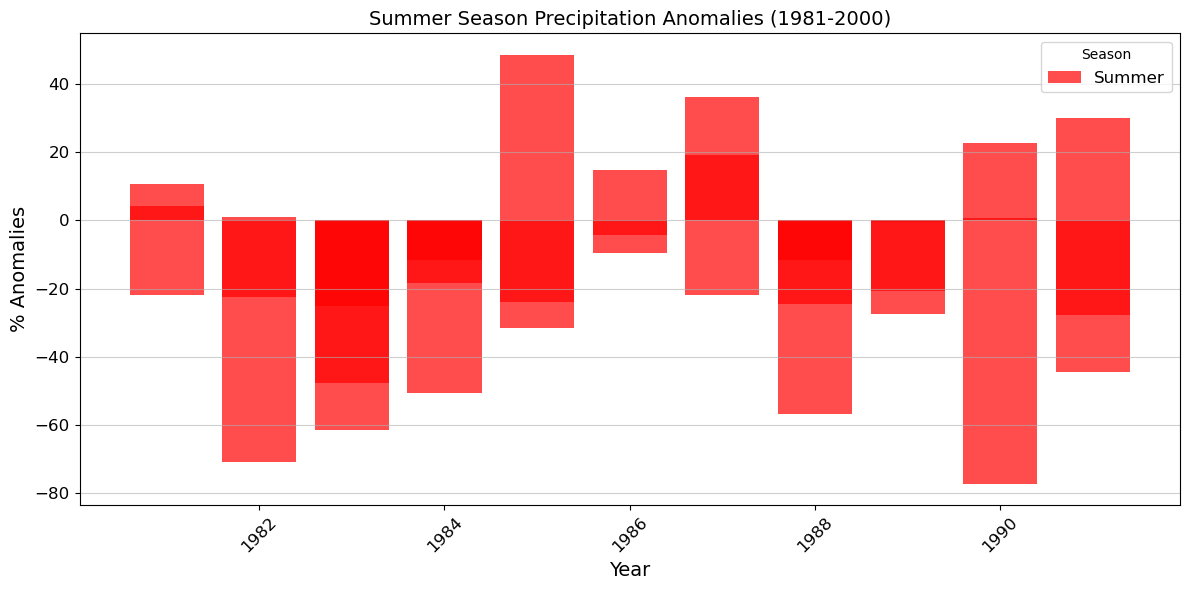

C:\Users\rande\AppData\Local\Temp\ipykernel_6444\3971666136.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  each_season_data = anomalies_till_2000[anomalies["Season"] == season]


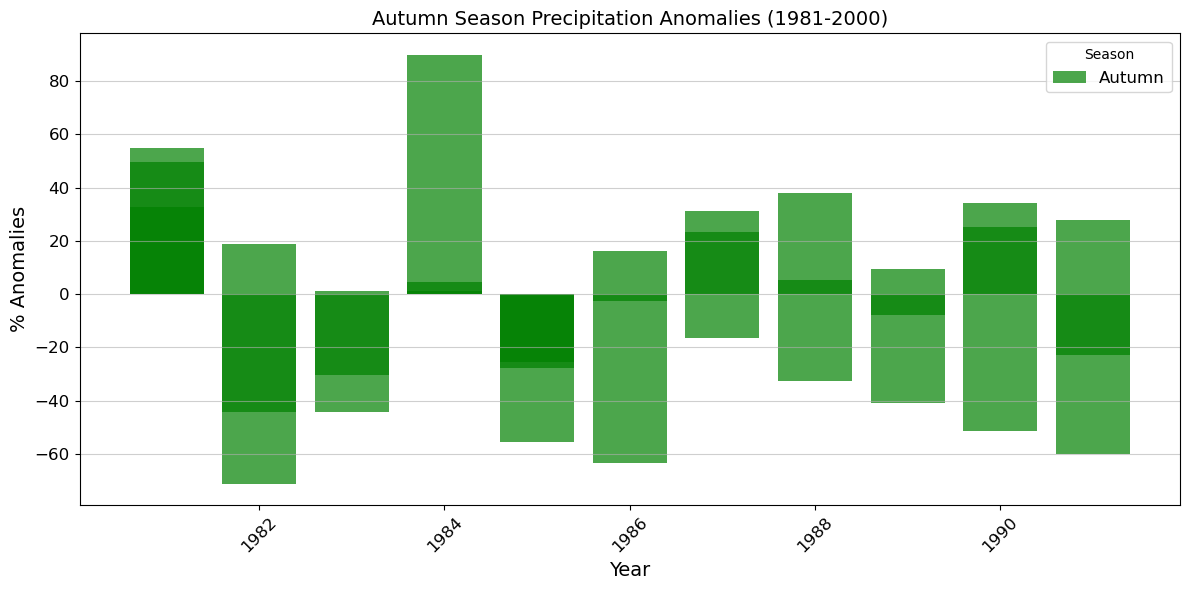

C:\Users\rande\AppData\Local\Temp\ipykernel_6444\3971666136.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  each_season_data = anomalies_till_2000[anomalies["Season"] == season]


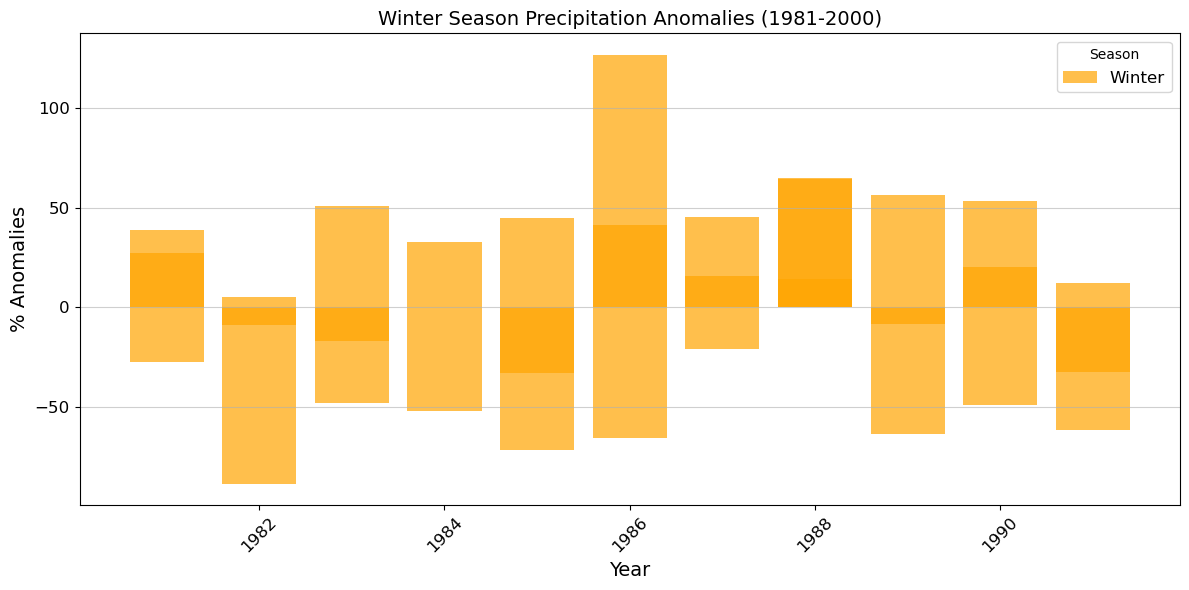

In [37]:
for i ,season in enumerate(seasons):
    plt.figure(figsize=(12, 6))
    each_season_data = anomalies_till_2000[anomalies["Season"] == season]
    #plt.plot(each_season_data["Year"],each_season_data["anomaly"], marker="o", linestyle="-") 
    plt.bar(each_season_data["Year"], each_season_data["anomaly"], label=season, alpha=0.7, color = color[i] )
    plt.grid(axis='y',  alpha=0.6)
    plt.xlabel("Year",fontsize = f_title)
    plt.ylabel("% Anomalies", fontsize= f_title)
    plt.title(f"{season} Season Precipitation Anomalies (1981-2000)", fontsize= f_title)
    plt.legend(title="Season", fontsize=f_other)
    plt.xticks(fontsize=f_other, rotation=45)
    plt.yticks(fontsize=f_other)

    plt.tight_layout()
    plt.show()

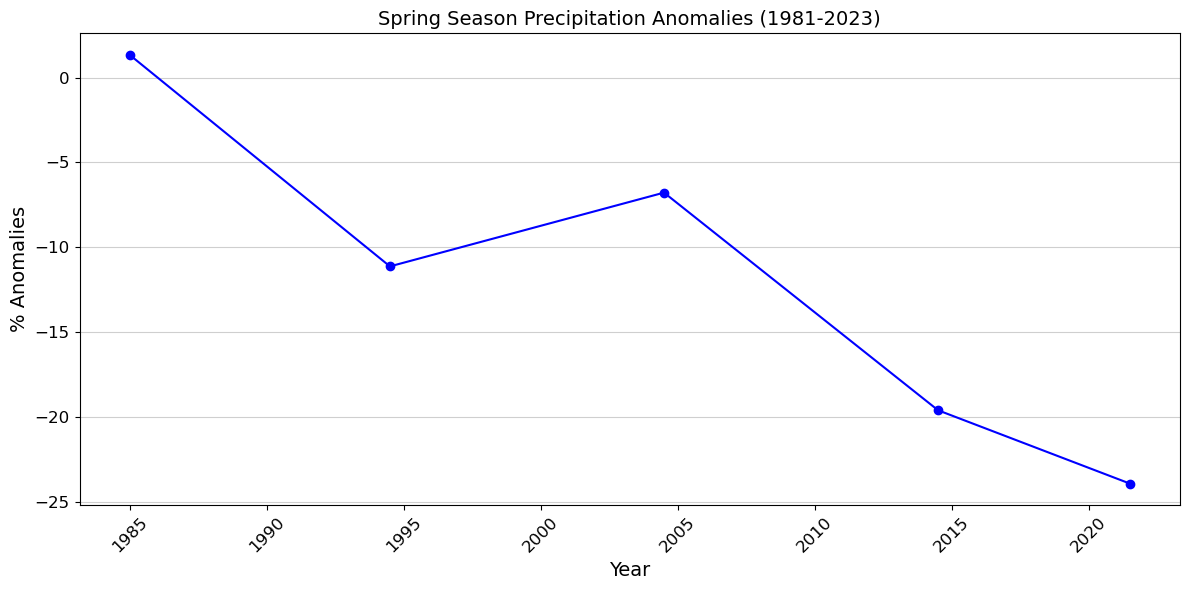

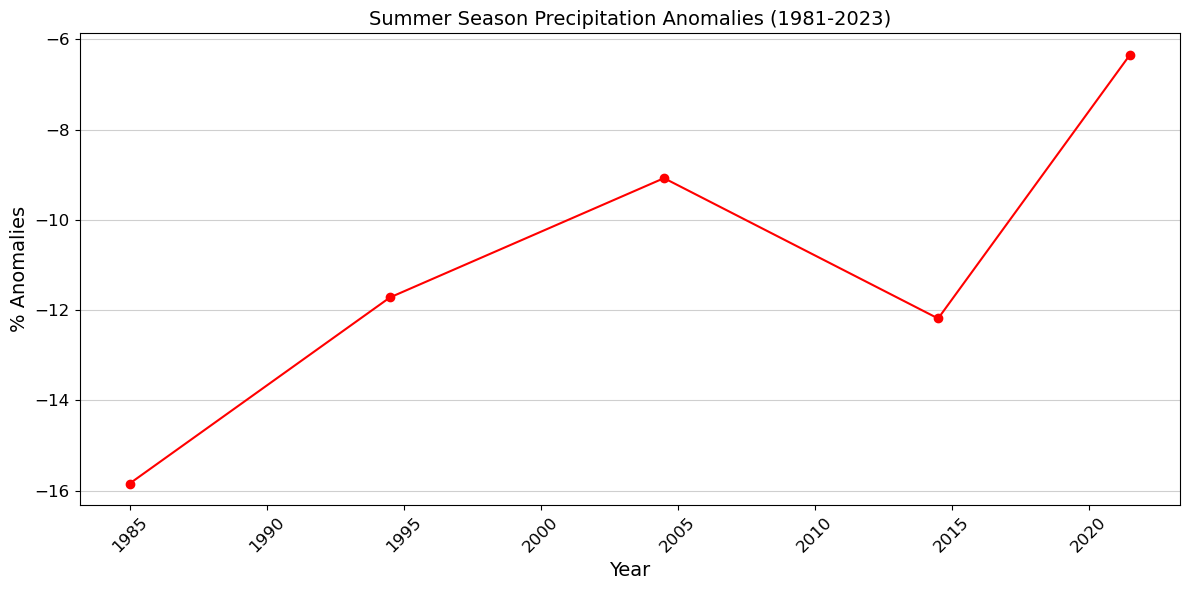

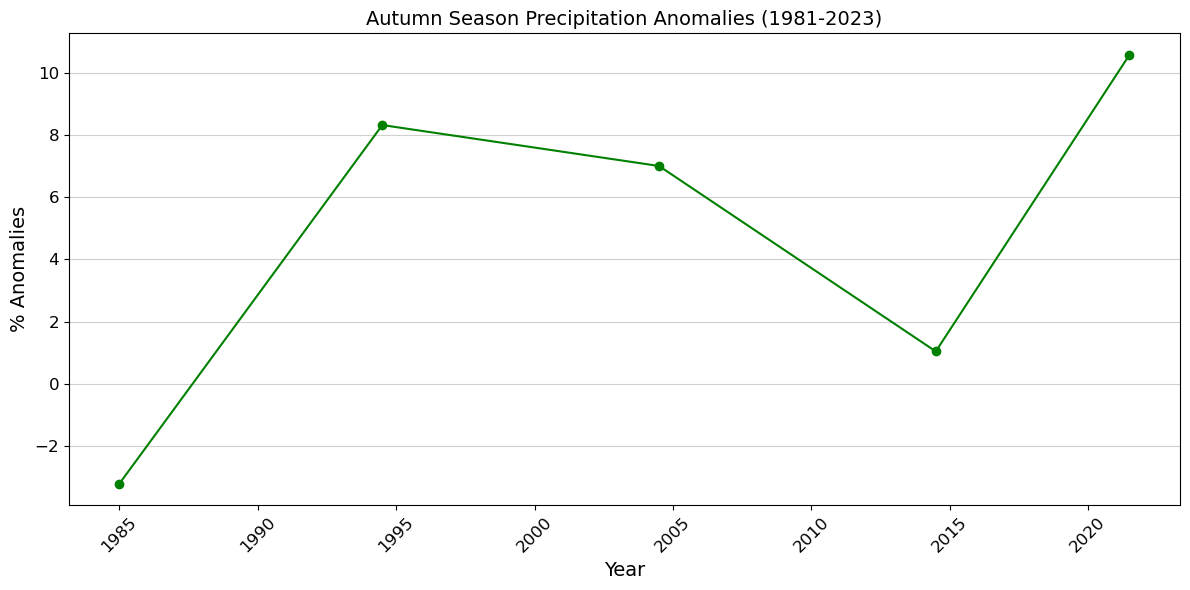

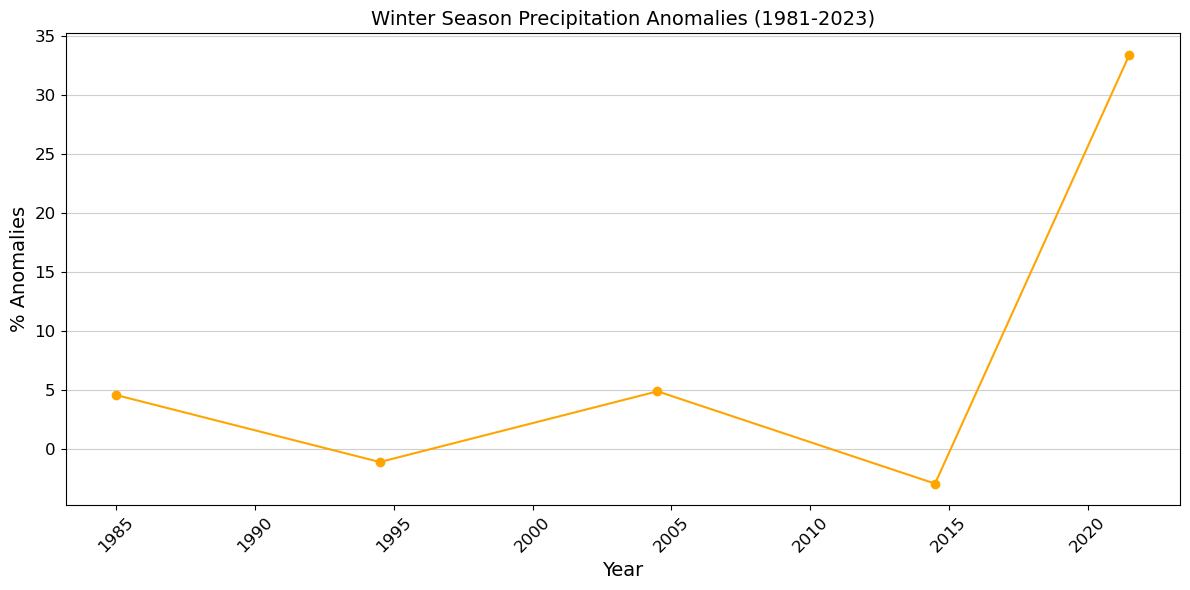

In [62]:
for i ,season in enumerate(seasons):
    plt.figure(figsize=(12, 6))
    each_decade_data = average_anomalies_by_decade[average_anomalies_by_decade["Season"] == season]
    plt.plot(each_decade_data["Year"], each_decade_data["anomaly"], marker="o", linestyle="-", color = color[i] )
    #plt.bar(each_decade_data["Year"], each_decade_data["anomaly"], label=season, alpha=0.7, color = color[i] )
    plt.grid(axis='y',  alpha=0.6)
    plt.xlabel("Year",fontsize = f_title)
    plt.ylabel("% Anomalies", fontsize= f_title)
    plt.title(f"{season} Season Precipitation Anomalies (1981-2023)", fontsize= f_title)
    plt.xticks(fontsize=f_other, rotation=45)
    plt.yticks(fontsize=f_other)

    plt.tight_layout()
    plt.show()

In [40]:
each_decade_data

,decade,Season,Year,precipitation,anomaly
3,1980,Winter,1985.0,1.963116,4.564344
7,1990,Winter,1994.5,1.856521,-1.113399
11,2000,Winter,2004.5,1.969039,4.879800
15,2010,Winter,2014.5,1.822161,-2.943554
19,2020,Winter,2021.5,2.504615,33.407023


In [66]:
Autm =  average_anomalies_by_decade[average_anomalies_by_decade["Season"] == 'Summer']
Autm 

,Year,Season,decade,precipitation,anomaly
2,1985.0,Summer,1980.0,2.220864,-15.845759
6,1994.5,Summer,1990.0,2.329761,-11.719396
10,2004.5,Summer,2000.0,2.399532,-9.075582
14,2014.5,Summer,2010.0,2.317447,-12.185977
18,2021.5,Summer,2020.0,2.471695,-6.341124
